In [2]:
import pybedtools

import numpy as np
import pandas as pd

import matplotlib as mpl
import matplotlib.pyplot as plt

import seaborn as sns
import seaborn.objects as so

from scipy.stats import pearsonr, spearmanr
import glob

## Read Data

In [3]:
path = "/sybig/projects/GeneRegulation/data/jme/Bachelorarbeit/data/Single_TFBS/All_TFBS.csv"
df_combined = pd.read_csv(path)

Flatten Genexpression

In [4]:
def flatten_tissues_expand_df(tfbs_df):
    tfbs_part_repeat = tfbs_df.iloc[:,:9]
    tfbs_part_flatten = tfbs_df.iloc[:,9:]
    
    repeat_df =  pd.DataFrame(np.repeat(tfbs_part_repeat.values, tfbs_part_flatten.shape[1], axis=0))
    flatten_arr = tfbs_part_flatten.to_numpy().flatten()

    tissue_repeat = np.tile(np.array(tfbs_part_flatten.columns), len(tfbs_part_repeat))
    
    repeat_df.columns = tfbs_part_repeat.columns
    repeat_df["GeneExpr"] = flatten_arr
    repeat_df["Tissue"] = tissue_repeat
    

    return repeat_df

In [5]:
flat_df = flatten_tissues_expand_df(df_combined)

Generate Pearson Corr csv

In [6]:
def get_pearson(df, tissue="GeneExpr"):
    tfs = df["tf"].unique()
    r_lst = []
    p_lst = []
    tf_lst = []
    for tf in tfs:
        df_tf = df[df["tf"] == tf]
        if len(df_tf) >= 2:
            r, p_value = pearsonr(df_tf["homotypic_count"], np.array(df_tf[tissue]))
            r_lst.append(r)
            p_lst.append(p_value)
            tf_lst.append(tf)
        else:
            print(f"{tf} has less then 2 entrys. No Correlation could be calculated")
    pearson_df = pd.DataFrame({"TFs":tf_lst, "Pearson_r":r_lst, "Pearson_p":p_lst})

    return pearson_df

In [10]:
#pearson_df = get_pearson(flat_df)
#pearson_df.to_csv("/sybig/projects/GeneRegulation/data/jme/Bachelorarbeit/data/Single_TFBS/Pearson_all_TFBS.csv", index=False)

In [7]:
# Calculate Variance of Geneexpression between Tissues
expr_mat = df_combined.iloc[:,9:].to_numpy()
variance = np.var(expr_mat, axis=1)

# Set the threshold as the median variance. This can be changed!
threshold = np.median(variance)

# Get new Dataframes, with genes with similiar expression
genes_with_similar_expression = df_combined.iloc[np.where(variance < threshold)[0]]
genes_with_similar_expression_flat = flatten_tissues_expand_df(genes_with_similar_expression)

## Plots Geneexpr

In [7]:
# Seaborn order 
grouped = flat_df[["tf", "All_tissues"]].groupby(["tf"])
order = grouped.median()["All_tissues"].sort_values(ascending=False).index

/sybig/home/jme/Bachelorarbeit/.venv/lib/python3.8/site-packages/numpy/lib/function_base.py:4573: RuntimeWarning: invalid value encountered in subtract
  diff_b_a = subtract(b, a)


<function matplotlib.pyplot.show(close=None, block=None)>

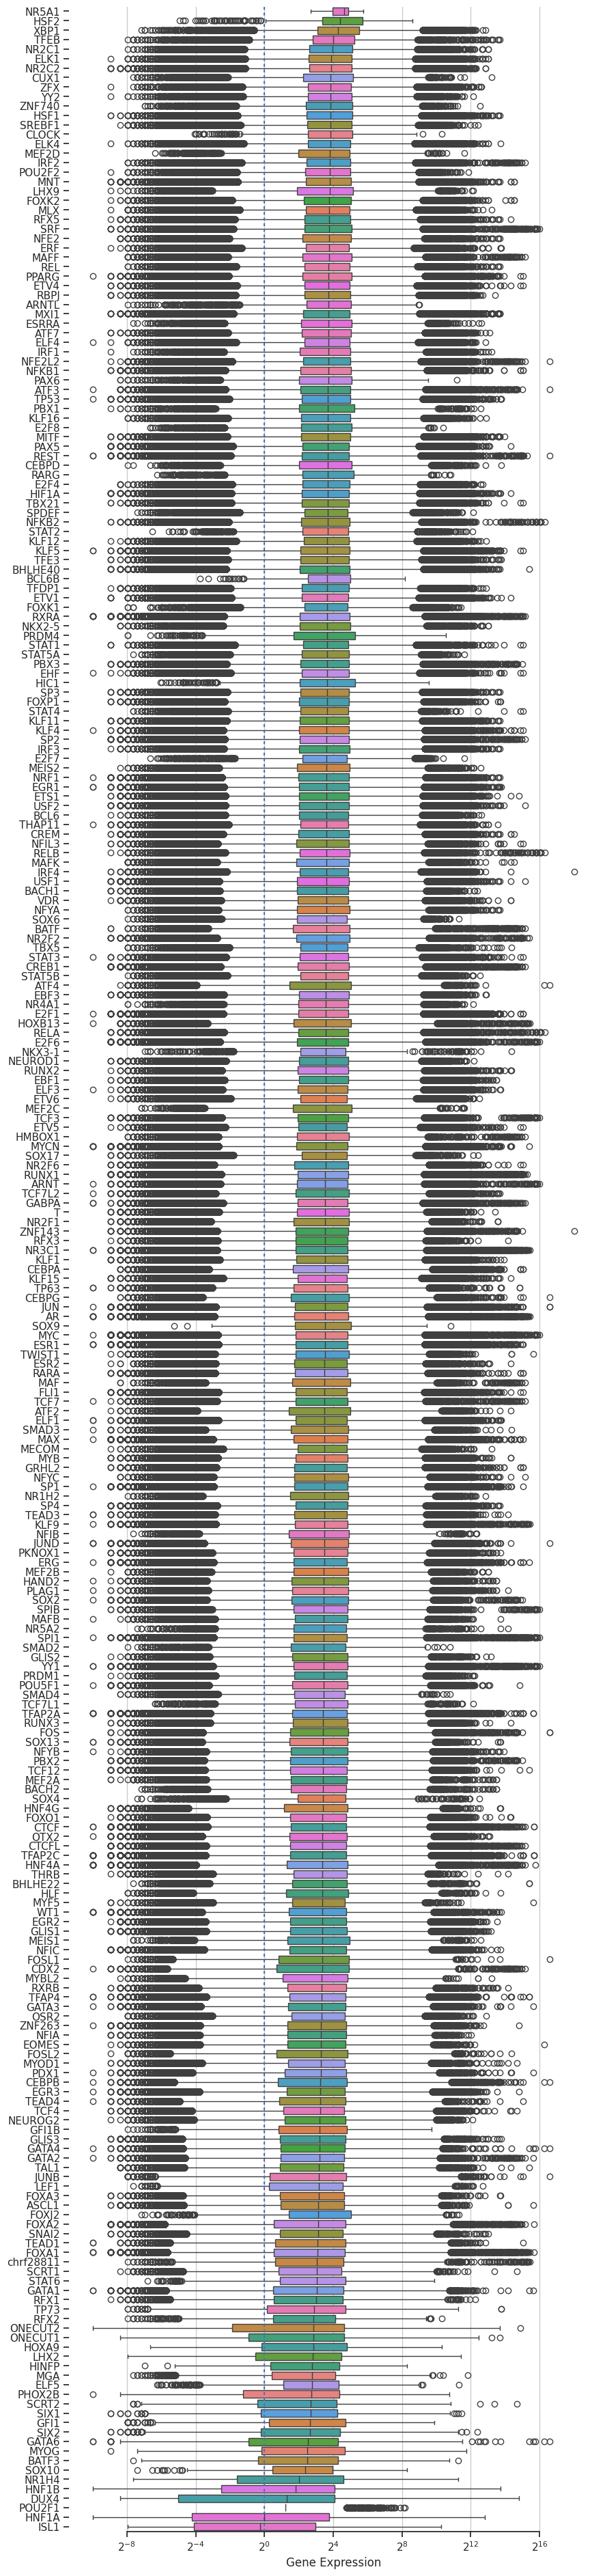

In [10]:
sns.set_theme(style="ticks")
fig, ax = plt.subplots(figsize=(10,48))
#ax.set_xscale("log", base=2)

sns.boxplot(flat_df, y="tf", x="All_tissues",hue="tf", log_scale=2, order = order)


ax.xaxis.grid(True)
ax.set(ylabel="")
ax.axvline(1, dashes=(2, 2))
sns.despine(trim=True, left=True)
ax.set_xlabel("Gene Expression")
fig.savefig("/sybig/projects/GeneRegulation/data/jme/Bachelorarbeit/data/Single_TFBS/Genexpression_All_TFBS.png")
plt.show

## Pearson Corr for all Tissues

### Generate Pearson Corr

In [8]:
def get_pearson(df):
    tfs = df.tf.unique()
    r_lst = []
    p_lst = []
    for tf in tfs:
        df_tf = df[df.tf == tf]
        r, p_value = pearsonr(df_tf.homotypic_count, df_tf.All_tissues)
        r_lst.append(r)
        p_lst.append(p_value)
    pearson_df = pd.DataFrame({"TFs":tfs, "Pearson_r":r_lst, "Pearson_p":p_lst})

    return pearson_df

In [39]:
pearson_df = get_pearson(flat_df)

KeyboardInterrupt: 

In [73]:
pearson_df

NameError: name 'pearson_df' is not defined

In [32]:
#pearson_df.to_csv("/sybig/projects/GeneRegulation/data/jme/Bachelorarbeit/data/Single_TFBS/Pearson_all_TFBS.csv", index=False)

### Refine Correlation Data and Plot

#### Load Data and Refine

In [8]:
pearson_df = pd.read_csv("/sybig/projects/GeneRegulation/data/jme/Bachelorarbeit/data/Single_TFBS/Pearson_all_TFBS.csv")

Sort DataFrame for Correlation, remove NANs, remove pvalues <0.05 and calculate -log10(p-value)

In [35]:
# Which TFBS have only one TFBS per Promotor?
na_r = pearson_df.Pearson_r.isna().to_numpy()
#pearson_df[na_r].TFs.to_numpy()


In [33]:
#pearson_df = pd.read_csv("/sybig/projects/GeneRegulation/data/jme/Bachelorarbeit/data/Single_TFBS/Pearson_all_TFBS.csv")
pearson_df_sort = pearson_df.reindex(pearson_df["Pearson_r"].abs().sort_values(ascending=False).index).dropna()
pearson_df_sort_pval = pearson_df_sort[pearson_df_sort["Pearson_p"] < 0.05]
pearson_df_sort_pval["Pearson_p"] = -np.log10(pearson_df_sort_pval["Pearson_p"])
pearson_df_sort_pval

/tmp/ipykernel_1490420/2549342215.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pearson_df_sort_pval["Pearson_p"] = -np.log10(pearson_df_sort_pval["Pearson_p"])


,TFs,Pearson_r,Pearson_p
29,TEAD1,0.103212,95.220875
237,ISL1,-0.095022,4.342716
248,TP73,0.083723,7.787387
3,CLOCK,-0.074272,2.697871
135,NR1H4,-0.072066,2.698383
...,...,...,...
146,CREM,-0.004063,1.314704
250,GABPA,-0.004001,2.005156
104,PAX5,0.003860,1.663108
263,KLF9,-0.003665,1.524081


In [42]:
# TFBS filterd out through p_value
filtered_tfbs = pearson_df_sort[pearson_df_sort["Pearson_p"] >= 0.05]
#filtered_tfbs.TFs.to_numpy()

Remove Entrys with p-value <0.05

In [48]:
pearson_df_sort_pval[pearson_df_sort_pval["Pearson_r"] < -0.05]

,TFs,Pearson_r,Pearson_p
237,ISL1,-0.095022,4.342716
3,CLOCK,-0.074272,2.697871
135,NR1H4,-0.072066,2.698383
161,RARG,-0.070992,5.769263
64,STAT5A,-0.068083,36.287392
192,CUX1,-0.065829,11.851917
233,ARNTL,-0.055923,4.367289


#### Plot Pearson Correlation

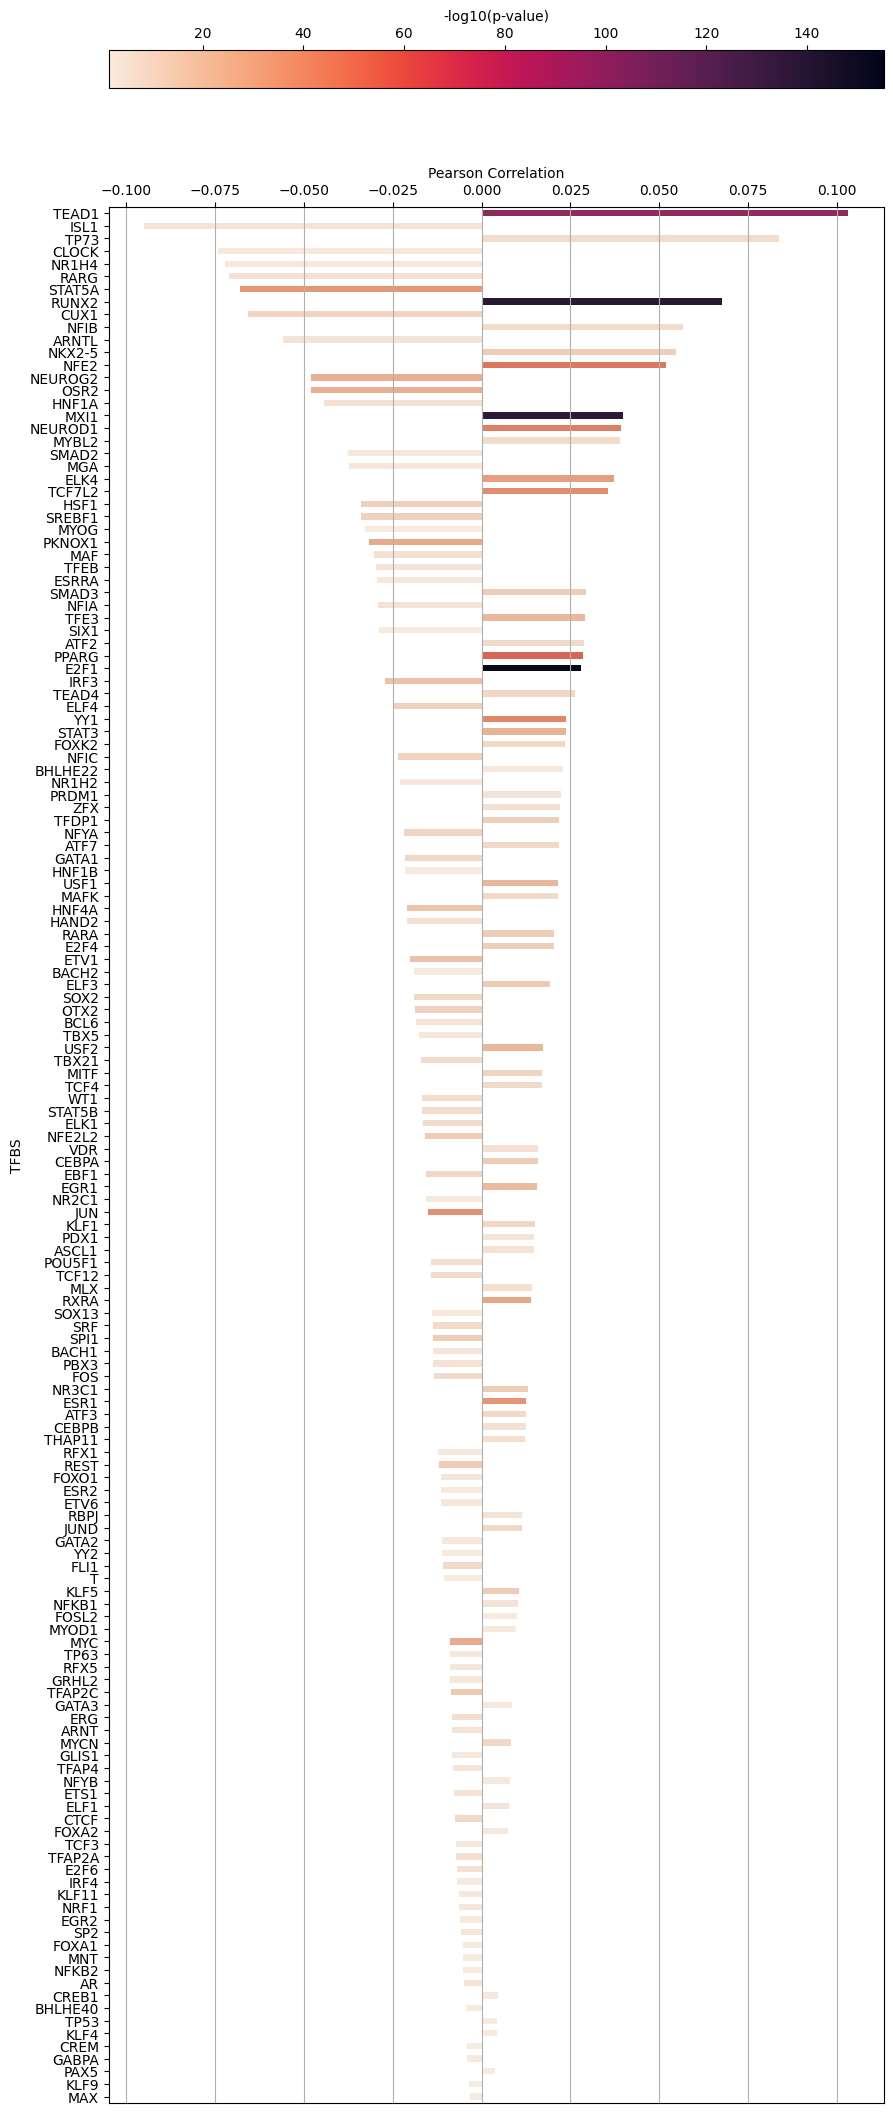

In [122]:
fig, ax = plt.subplots(figsize=(10,30))

norm = plt.Normalize(pearson_df_sort_pval["Pearson_p"].min(), pearson_df_sort_pval["Pearson_p"].max())
sm = plt.cm.ScalarMappable(cmap="rocket_r", norm=norm)

sns.barplot(pearson_df_sort_pval, x="Pearson_r", y="TFs",hue="Pearson_p", width=0.5, palette="rocket_r")


ax.set_ylabel('TFBS')

ax.xaxis.tick_top()
ax.set_xlabel('Pearson Correlation')
ax.xaxis.set_label_position("top")

ax.xaxis.grid(True)
ax.get_legend().remove()

plt.subplots_adjust(top=0.9)
cbar = ax.figure.colorbar(sm, ax=ax, orientation= "horizontal", location="top", )
cbar.set_label("-log10(p-value)")

#fig.savefig("/sybig/projects/GeneRegulation/data/jme/Bachelorarbeit/data/Single_TFBS/Boxplot/Pearson_corr_all_great_p.png")


## Pearson Corr, different distance bins

### Split Data in different bins

In [7]:
flat_df

,chr,geneID,tf,close_tss,dist_tss,strand_orientation,homotypic_count,all_tfbs_count,all_tfbs_unique_count,All_tissues
0,chr1,ENSG00000163209.14,HMBOX1,159,169,nT,1,24,20,0.691
1,chr1,ENSG00000163209.14,HMBOX1,159,169,nT,1,24,20,1.043
2,chr1,ENSG00000163209.14,HMBOX1,159,169,nT,1,24,20,1.906
3,chr1,ENSG00000163209.14,HMBOX1,159,169,nT,1,24,20,1.397
4,chr1,ENSG00000163209.14,HMBOX1,159,169,nT,1,24,20,1.385
...,...,...,...,...,...,...,...,...,...,...
37849459,chr7,ENSG00000128512.20,STAT5B,105,120,T,1,104,79,2.226
37849460,chr7,ENSG00000128512.20,STAT5B,105,120,T,1,104,79,7.504
37849461,chr7,ENSG00000128512.20,STAT5B,105,120,T,1,104,79,11.100
37849462,chr7,ENSG00000128512.20,STAT5B,105,120,T,1,104,79,6.597


In [23]:
dist_avg = (np.array(flat_df["dist_tss"]) + np.array(flat_df["close_tss"]))/2

bin_1 = flat_df[dist_avg < 50]
bin_2 = flat_df[(dist_avg >= 50) & (dist_avg < 100)]
bin_3 = flat_df[(dist_avg >= 100) & (dist_avg < 150)]
bin_4 = flat_df[dist_avg > 150]

### Generate Pearson_correlation for every single Bin

In [26]:
pearson_df_bin_1 = get_pearson(bin_1)
#pearson_df_bin_1.to_csv("/sybig/projects/GeneRegulation/data/jme/Bachelorarbeit/data/Single_TFBS/Pearson_bin_1_lower_50.csv", index=False)

/sybig/home/jme/Bachelorarbeit/.venv/lib/python3.8/site-packages/scipy/stats/_stats_py.py:4424: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(msg))


In [27]:
pearson_df_bin_2 = get_pearson(bin_2)
pearson_df_bin_2.to_csv("/sybig/projects/GeneRegulation/data/jme/Bachelorarbeit/data/Single_TFBS/Pearson_bin_2_50_100.csv", index=False)

In [28]:
pearson_df_bin_3 = get_pearson(bin_3)
pearson_df_bin_3.to_csv("/sybig/projects/GeneRegulation/data/jme/Bachelorarbeit/data/Single_TFBS/Pearson_bin_3_100_150.csv", index=False)

In [29]:
pearson_df_bin_4 = get_pearson(bin_4)
pearson_df_bin_4.to_csv("/sybig/projects/GeneRegulation/data/jme/Bachelorarbeit/data/Single_TFBS/Pearson_bin_4_greater_150.csv", index=False)

### Load Data and Plot all Bins

In [30]:
pearson_bin_1 = pd.read_csv("/sybig/projects/GeneRegulation/data/jme/Bachelorarbeit/data/Single_TFBS/Pearson_bin_1_lower_50.csv")
pearson_bin_2 = pd.read_csv("/sybig/projects/GeneRegulation/data/jme/Bachelorarbeit/data/Single_TFBS/Pearson_bin_2_50_100.csv")
pearson_bin_3 = pd.read_csv("/sybig/projects/GeneRegulation/data/jme/Bachelorarbeit/data/Single_TFBS/Pearson_bin_3_100_150.csv")
pearson_bin_4 = pd.read_csv("/sybig/projects/GeneRegulation/data/jme/Bachelorarbeit/data/Single_TFBS/Pearson_bin_4_greater_150.csv")

In [35]:
def refine_pearson_df(pearson_df):
    pearson_df_sort = pearson_df.reindex(pearson_df["Pearson_r"].abs().sort_values(ascending=False).index).dropna()
    pearson_df_sort_pval = pearson_df_sort[pearson_df_sort["Pearson_p"] < 0.05]
    pearson_df_sort_pval["Pearson_p"] = -np.log10(pearson_df_sort_pval["Pearson_p"])
    return pearson_df_sort_pval

In [58]:
p1 = refine_pearson_df(pearson_bin_1)
p2 = refine_pearson_df(pearson_bin_2)
p3 = refine_pearson_df(pearson_bin_3)
p4 = refine_pearson_df(pearson_bin_4)


/tmp/ipykernel_1227001/48341807.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pearson_df_sort_pval["Pearson_p"] = -np.log10(pearson_df_sort_pval["Pearson_p"])


##### Plot single Bin

In [ ]:
# Set Colorbar to min and max of all tfbs
min_p_value = min(p1["Pearson_p"].min(), p2["Pearson_p"].min(), p3["Pearson_p"].min(), p4["Pearson_p"].min())
max_p_value = max(p1["Pearson_p"].max(), p2["Pearson_p"].max(), p3["Pearson_p"].max(), p4["Pearson_p"].max())
#min_p_value = p4["Pearson_p"].min()
#max_p_value = p4["Pearson_p"].max()
norm = plt.Normalize(min_p_value, max_p_value)
sm = plt.cm.ScalarMappable(cmap="rocket_r", norm=norm)

# Plot all 4 plots 
fig, ax = plt.subplots(1, 4, figsize=(10,30))


sns.barplot(p4, x="Pearson_r", y="TFs",hue="Pearson_p", width=0.5, palette="rocket_r", hue_norm=norm)


ax.set_ylabel('TFBS')

ax.xaxis.tick_top()
ax.set_xlabel('Pearson Correlation')
ax.xaxis.set_label_position("top")

ax.xaxis.grid(True)
ax.get_legend().remove()

plt.subplots_adjust(top=0.9)
cbar = ax.figure.colorbar(sm, ax=ax, orientation= "horizontal", location="top", )
cbar.set_label("-log10(p-value)")

# fig.savefig("/sybig/projects/GeneRegulation/data/jme/Bachelorarbeit/data/Single_TFBS/Boxplot/Pearson_corr_all_bins.png")

##### Plot all bins

## Pearson Corr, all Tissues

In [141]:
df_combined["max_tissue_value"] = df_combined.iloc[:,9:].max(axis=1)

In [144]:
pearson_max_tissue = get_pearson(df_combined, tissue="max_tissue_value")
pearson_max_tissue.to_csv("/sybig/projects/GeneRegulation/data/jme/Bachelorarbeit/data/Single_TFBS/Pearson_all_tfbs_max_tissue.csv", index=False)

/sybig/home/jme/Bachelorarbeit/.venv/lib/python3.8/site-packages/scipy/stats/_stats_py.py:4424: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(msg))


NR5A1 has less then 2 entrys. No Correlation could be calculated


NameError: name 'pearson_df' is not defined

In [146]:
pearson_max_tissue = pd.read_csv()

## Pearson Corr, only #TFBS > 3

## Pearson Corr, only genes with similiar expr

In [11]:
pearson_similiar_expr = get_pearson(genes_with_similar_expression_flat)

/sybig/home/jme/Bachelorarbeit/.venv/lib/python3.8/site-packages/scipy/stats/_stats_py.py:4424: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(msg))


In [12]:
pearson_similiar_expr.to_csv("/sybig/projects/GeneRegulation/data/jme/Bachelorarbeit/data/Single_TFBS/Pearson_similiar_genexpr.csv", index=False)

In [ ]:
# pearson_similiar_expr = pd.read_csv("/sybig/projects/GeneRegulation/data/jme/Bachelorarbeit/data/Single_TFBS/Pearson_similiar_genexpr.csv")

In [25]:
pearson_similiar_expr_sort = pearson_similiar_expr.reindex(pearson_similiar_expr["Pearson_r"].abs().sort_values(ascending=False).index).dropna()
pearson_similiar_expr_pval = pearson_similiar_expr_sort[pearson_similiar_expr_sort["Pearson_p"] < 0.05]
#pearson_df_sort_pval["Pearson_p"] = -np.log10(pearson_df_sort_pval["Pearson_p"])
pearson_similiar_expr_pval_pearson_greater_01 = pearson_similiar_expr_pval[(pearson_similiar_expr_pval["Pearson_r"]>=0.1) | (pearson_similiar_expr_pval["Pearson_r"]<=-0.1)]
pearson_similiar_expr_pval_pearson_greater_01

,TFs,Pearson_r,Pearson_p
3,CLOCK,0.370797,8.400292e-28
192,CUX1,0.280415,2.534344e-93
135,NR1H4,-0.272316,2.113428e-13
6,PHOX2B,-0.231282,8.143141e-99
223,LHX9,0.225138,1.353411e-82
194,LEF1,0.219198,1.634578e-43
38,XBP1,0.199660,1.351529e-128
31,MAF,-0.176455,1.482932e-85
237,ISL1,-0.170092,1.615853e-09
230,ESRRA,0.147664,7.767865e-25


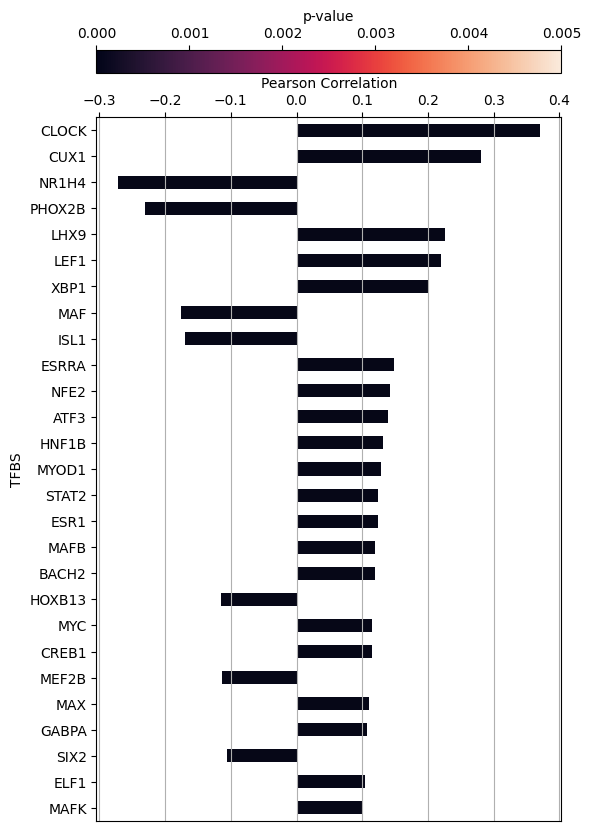

In [31]:
# Set Colorbar to min and max of all tfbs
#min_p_value = min(p1["Pearson_p"].min(), p2["Pearson_p"].min(), p3["Pearson_p"].min(), p4["Pearson_p"].min())
#max_p_value = max(p1["Pearson_p"].max(), p2["Pearson_p"].max(), p3["Pearson_p"].max(), p4["Pearson_p"].max())
min_p_value = pearson_similiar_expr_pval_pearson_greater_01["Pearson_p"].min()
max_p_value = pearson_similiar_expr_pval_pearson_greater_01["Pearson_p"].max()
norm = plt.Normalize(0, 0.005)
sm = plt.cm.ScalarMappable(cmap="rocket", norm=norm)

# Plot all 4 plots 
fig, ax = plt.subplots(figsize=(6,10))


sns.barplot(pearson_similiar_expr_pval_pearson_greater_01, x="Pearson_r", y="TFs",hue="Pearson_p", width=0.5, palette="rocket", hue_norm=norm)


ax.set_ylabel('TFBS')

ax.xaxis.tick_top()
ax.set_xlabel('Pearson Correlation')
ax.xaxis.set_label_position("top")

ax.xaxis.grid(True)
ax.get_legend().remove()

plt.subplots_adjust(top=0.99)
cbar = ax.figure.colorbar(sm, ax=ax, orientation= "horizontal", location="top", )
cbar.set_label("p-value")

#fig.savefig("/sybig/projects/GeneRegulation/data/jme/Bachelorarbeit/data/Single_TFBS/Boxplot/Pearson_corr_similiar_Expr_02.png")